Whenever a setup cell is modified, it must be rerun for the change to be reflected in calls to model functions.

Like most nonlinear fits, the fit results can be highly sensitive to the choice of initial guess, particularly as the number of fitted parameters increases.  Some tips if your results seem sensetive to initial guess:

(1) Use plot fit code block to get your initial guess close to something reasonable.  If you're unable to get something visually close by adjusting the initial guess, then it's a good indication that your model is not describing the phenomenon you are trying to capture, some fixed parameters are innacurate, etc.  I've found that the results are much more sensitive to initial guess when the fit quality is visually poor.

(2) Consider the error bars on the parameters - are the results from different when initial guesses are varied?  Or are the results within error?  Bootstrap will typically give you a MUCH more accurate sense of your error, which is typically larger than the error outputted solely from the fit.

(3) Also consider covariance.  If one fitted parameter changed substantailly, did any parameters to which it is highly correlated also change?  This suggests your model / data cannot independently determine these two parameters, and they are only varying within error (see above point).

(4) Try decreasing ftol/xol or increasing maxfev (whichever is causing the solver to terminate) - in practice, this hasn't made much of a difference.

err_weight = False tends to give better fits when a species has poor signal to noise (like OH)

## Setup: Modules

These are the bare minimum modules required to run the code in this example notebook.  Feel free to import more if you add your own custom functionality to the notebook (e.g. matplotlib or seaborn for plots).

In [1]:
import numpy as np
import pandas as pd
from IPython.display import display
import ALS

## Setup: User Model

Must instantiate KineticModel object after defining user model.

In [2]:
from ex_model_1 import model_H2O2_depletion
model = ALS.KineticModel(model_H2O2_depletion)

## Setup: Species Data

Step 1:

Should this be changed to load the t-axis from the data file?  I prefer no.

In [3]:
tbin = 10                    # tbin used when data was loaded from Igor
t_start = -20                # Trim the data to t_start inclusive (ms)
t_end = 59.8                 # Trim the data to t_end inclusive (ms)
fn_val = 'ex_data_val_1.csv' # Filename for the data values
fn_err = 'ex_data_err_1.csv' # Filename for the error in the data

dt = 0.02                    # Fundaemental kinetic time step (ms)
t = np.linspace(-20,130,num=int(150/(dt*tbin)),endpoint=False)

df_val = pd.read_csv(fn_val)
df_err = pd.read_csv(fn_err)

idx_start = np.abs(t-t_start).argmin()
idx_end = np.abs(t-t_end).argmin()
drop_indices = np.concatenate((np.arange(idx_start),np.arange(idx_end+1,t.size)))

t = t[idx_start:idx_end+1]
df_val = df_val.drop(drop_indices, axis=0).reset_index(drop=True)
df_err = df_err.drop(drop_indices, axis=0).reset_index(drop=True)

Step 2:

In [23]:
data = {}
data['H2O2'] = {'val':df_val['H2O2'].values, 'err':df_err['H2O2'].values, 'fit':True, 'weight':3}
data['HO2']  = {'val':df_val['HO2'].values,  'err':df_err['HO2'].values,  'fit':True, 'weight':3}
data['OH']   = {'val':df_val['OH'].values,   'err':df_err['OH'].values,   'fit':True, 'weight':3}
data = pd.DataFrame.from_dict(data, orient='index')
display(data)

,val,err,fit,weight
H2O2,"[6135.0, 6162.0, 6025.0, 6005.0, 6027.0, 6101....","[78.326, 78.498, 77.621, 77.492, 77.634, 78.10...",True,3
HO2,"[-3.15, -4.15, -3.15, -4.15, 5.85, 6.85, -1.15...","[5.0, 4.899, 5.0, 4.899, 5.831, 5.9161, 5.1962...",True,3
OH,"[-0.82, 0.18, 0.18, -0.82, -0.82, -0.82, 1.18,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.4142, 1.0, 1....",True,3


## Setup: Model and ALS Parameters

In [19]:
c_H2O2_0 = 5.25e14
idx_zero = np.abs(t-(-1.68)).argmin()
S_H2O2 = df_val.iloc[:idx_zero,df_val.columns.get_loc('H2O2')].mean() / c_H2O2_0

model_params = {}
model_params['X0'] =         {'val':4.2e12,     'err':0,  'fit':True}
model_params['k_OH_wall'] =  {'val':25,        'err':0, 'fit':True}
model_params['k_HO2_wall'] = {'val':6,        'err':0, 'fit':True}
model_params['T'] =          {'val':298.,       'err':0,  'fit':False}
model_params['P'] =          {'val':30.,        'err':0,  'fit':False}
model_params['c_H2O2_0'] =   {'val':c_H2O2_0,   'err':0,  'fit':False}
model_params = pd.DataFrame.from_dict(model_params, orient='index')

print('Inputted Model Params:')
display(model_params)

ALS_params = {}
ALS_params['S_H2O2'] =  {'val':S_H2O2,    'err':0, 'fit':False}
ALS_params['S_OH'] =    {'val':3.6e-11,     'err':0, 'fit':True}
ALS_params['S_HO2'] =   {'val':2.6e-10,     'err':0, 'fit':True}
ALS_params['A'] =       {'val':-0.022,  'err':0, 'fit':False}
ALS_params['B'] =       {'val':4.85e-3,   'err':0, 'fit':False}
ALS_params['t0'] =      {'val':-0.5,     'err':0, 'fit':False}
ALS_params = pd.DataFrame.from_dict(ALS_params, orient='index')

print('Inputted ALS Params:')
display(ALS_params)

Inputted Model Params:


,val,err,fit
P,3.000000e+01,0,False
T,2.980000e+02,0,False
X0,4.200000e+12,0,True
c_H2O2_0,5.250000e+14,0,False
k_HO2_wall,6.000000e+00,0,True
k_OH_wall,2.500000e+01,0,True


Inputted ALS Params:


,val,err,fit
A,-2.200000e-02,0,False
B,4.850000e-03,0,False
S_H2O2,1.149961e-11,0,False
S_HO2,2.600000e-10,0,True
S_OH,3.600000e-11,0,True
t0,-5.000000e-01,0,False


## Perform a fit

Optimization terminated successfully.
Exit Code = 3
Exit Message = Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000 and the relative error between two consecutive iterates is at 
  most 0.000000

Optimized Cost Function Value = 2918.73

Optimized Parameters and Standard Errors:


,val,err
X0,3.882548e+12,7.162173e+10
k_HO2_wall,5.929612e+00,1.016574e-01
k_OH_wall,2.489296e+01,3.797989e-01
S_HO2,2.713226e-10,3.579841e-12
S_OH,2.342285e-11,1.293549e-12



Correlation Matrix:


,X0,k_HO2_wall,k_OH_wall,S_HO2,S_OH
X0,1.000000,-0.581948,-0.449388,-0.971762,-0.294183
k_HO2_wall,-0.581948,1.000000,-0.014569,0.655176,0.161368
k_OH_wall,-0.449388,-0.014569,1.000000,0.451625,0.123367
S_HO2,-0.971762,0.655176,0.451625,1.000000,0.283551
S_OH,-0.294183,0.161368,0.123367,0.283551,1.000000


<IPython.core.display.Javascript object>


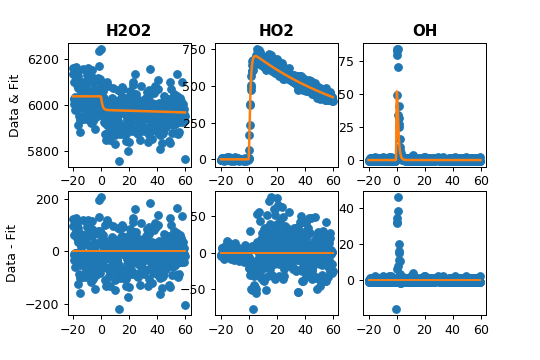

Cost Function Value: 2.09914e+06


In [27]:
%matplotlib notebook

df_p, df_cov_p, df_corr_p, cost, mesg, ier \
    = model.fit(t, tbin, data, model_params, ALS_params, err_weight=True)

## Plot the data overlaid with the scaled model

Important: Despite the plot_fit name, this function does not actually perform a fit.


Use cases:
1. plotting a previous fit without having to rerun the fit code\n
2. playing around with initial guesses before performing a fit\n
3. saving optimized model * scale factor for each species in order to plot elsewere

<IPython.core.display.Javascript object>


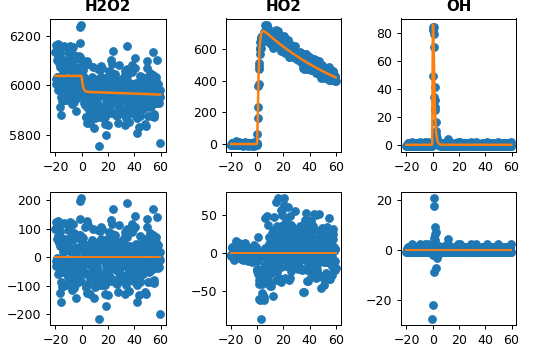

Cost Function Value: 2.08421e+06


In [20]:
% matplotlib notebook
model.plot_fit(t, tbin, data, model_params, ALS_params)

In [28]:
import importlib
importlib.reload(ALS)
model = ALS.KineticModel(model_H2O2_depletion)